In [1]:
# %matplotlib notebook

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import time
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

cuda


In [2]:
dataset_root_dir = './BSD68/images'

In [3]:
class NoisyBSDSDataset(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=22):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('L')
        # random crop
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        transform = tv.transforms.Compose([
            # convert it to a tensor
            tv.transforms.ToTensor(),
            # normalize it to the range [−1, 1]
            tv.transforms.Normalize(.5, .5)
            ])
        clean = transform(clean)
        
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

In [4]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image,cmap='gray')
    ax.axis('off')
    return h

In [5]:
train_set = NoisyBSDSDataset(dataset_root_dir,sigma=22)
test_set = NoisyBSDSDataset(dataset_root_dir, mode='test', image_size=(320, 320),sigma=22)

In [6]:
class NNRegressor(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

In [7]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(1, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 1, 3, padding=1))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

In [8]:
class DenoisingStatsManager(nt.StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)    
        n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
        self.running_psnr += 10*torch.log10(4*n/(torch.norm(y-d)**2))

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

In [9]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')
    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k][0]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()

In [10]:
lr = 1e-3
net = DnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="./checkpoints/denoising22_normal", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 | Time: 2.47s | Training Loss: 0.099678 | Evaluation Loss: 0.041427
Epoch 2 | Time: 0.93s | Training Loss: 0.030464 | Evaluation Loss: 0.023952
Epoch 3 | Time: 0.91s | Training Loss: 0.020962 | Evaluation Loss: 0.018456
Epoch 4 | Time: 0.93s | Training Loss: 0.017288 | Evaluation Loss: 0.016087
Epoch 5 | Time: 0.90s | Training Loss: 0.015591 | Evaluation Loss: 0.014957
Epoch 6 | Time: 0.89s | Training Loss: 0.014661 | Evaluation Loss: 0.013861
Epoch 7 | Time: 0.90s | Training Loss: 0.013869 | Evaluation Loss: 0.013227
Epoch 8 | Time: 0.94s | Training Loss: 0.012934 | Evaluation Loss: 0.013061
Epoch 9 | Time: 0.92s | Training Loss: 0.012901 | Evaluation Loss: 0.012607
Epoch 10 | Time: 0.94s | Training Loss: 0.012505 | Evaluation Loss: 0.012045
Epoch 11 | Time: 0.91s | Training Loss: 0.012050 | Evaluation Loss: 0.011872
Epoch 12 | Time: 0.92s | Training Loss: 0.012026 | Evaluation Loss: 0.011699
Epoch 13 | Time: 1.00s | Training Loss: 0.011532

Epoch 107 | Time: 0.95s | Training Loss: 0.007074 | Evaluation Loss: 0.007404
Epoch 108 | Time: 0.95s | Training Loss: 0.006902 | Evaluation Loss: 0.006977
Epoch 109 | Time: 0.93s | Training Loss: 0.007057 | Evaluation Loss: 0.007206
Epoch 110 | Time: 0.93s | Training Loss: 0.006963 | Evaluation Loss: 0.007008
Epoch 111 | Time: 0.93s | Training Loss: 0.007317 | Evaluation Loss: 0.007494
Epoch 112 | Time: 0.93s | Training Loss: 0.006900 | Evaluation Loss: 0.007074
Epoch 113 | Time: 0.97s | Training Loss: 0.007062 | Evaluation Loss: 0.007512
Epoch 114 | Time: 0.95s | Training Loss: 0.006981 | Evaluation Loss: 0.007202
Epoch 115 | Time: 1.00s | Training Loss: 0.006913 | Evaluation Loss: 0.007208
Epoch 116 | Time: 0.94s | Training Loss: 0.007056 | Evaluation Loss: 0.007187
Epoch 117 | Time: 0.99s | Training Loss: 0.007101 | Evaluation Loss: 0.007093
Epoch 118 | Time: 0.95s | Training Loss: 0.007161 | Evaluation Loss: 0.007419
Epoch 119 | Time: 0.95s | Training Loss: 0.007422 | Evaluation L

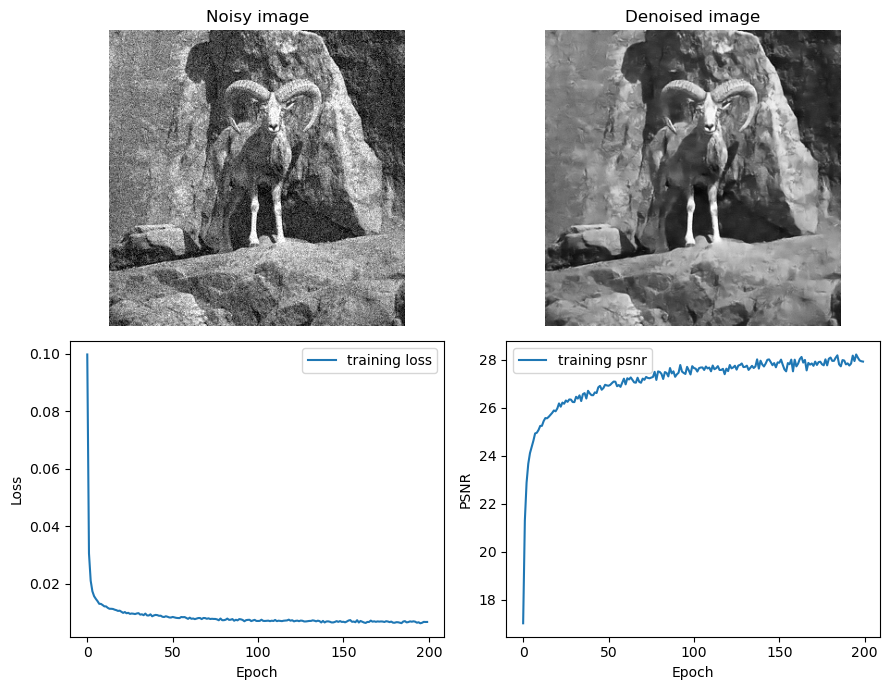

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[0][0]))

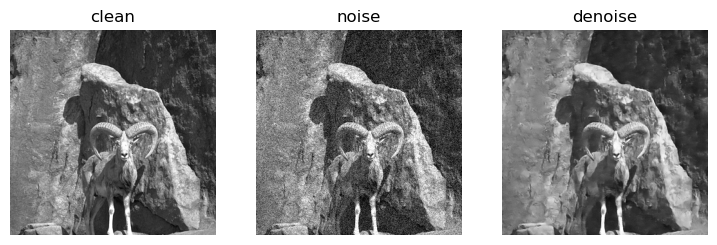

In [12]:
img = []
model = exp1.net.to(device)
titles = ['clean', 'noise', 'denoise']

x, clean = test_set[0]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

In [13]:
torch.save(model,'model22_normal.pth')